# Recommender system
**Project Description:** Prediction of goods rating for exact user-item pairs.

**Goal:** To recommend the best product for the user.

**Objectives:** Create model to predict goods rating for user-item pairs.

**Dataset Description:** Dataset consists of 857895 rows into train set and 285965 rows into test set.

Dataset features:

1. overall - rating given by the user;
2. verified - whether the review was verified;
3. reviewTime - when was the review written;
4. reviewerName - user name;
5. reviewText;
6. summary - concise review;
7. vote - number of votes for the review;
8. style - metadata;
9. image - product picture;
10. userid - user id;
11. itemid - product id;
12. id - id for prediction.

In [1]:
import os
import re
import math
import json
import statistics
from collections import Counter, defaultdict
from itertools import chain, combinations
from pprint import pprint

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm import tqdm
from sklearn.base import clone
from sklearn.metrics import SCORERS, make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import f_classif, mutual_info_classif
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split

pd.options.display.max_columns = 40

In [2]:
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json
/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/working/__notebook__.ipynb


In [3]:
# Save requirements
!pip freeze > requirements.txt

In [4]:
# G L O B A L   C O N S T A N T S
# Random seed
RANDOM_SEED = 42
# Suffix for features with power of -1
MINUS_ONE_SUFFIX = '_1'
# Suffix for duplicated features in various feature category
DUPLICATE_SUFFIX = '_dup'
# Target feature
TARGET = 'overall'
# ID feature
IDENT = 'Id'
# Binary feature to separate train and test data
TRAIN = 'TRAIN'
# Feature of random numbers
RANDOM = 'RANDOM'
# Target metric
METRIC = 'roc_auc'
# Problem type: 'Regression' or 'Classification'
PROBLEM = 'RecommenderSystem'
# Data, kernel and working paths
PATH_DATA = '/kaggle/input/recommendationsv4/'
PATH_KERNEL = '/kaggle/input/recommender-system/'
PATH_WORKING = '/kaggle/working/'
# Flag of availability to drop rows
DROP_AVAL = False

# Data preparing
## Collecting and formating

In [5]:
def collect_data():
    """Read train and test datasets and join them"""
    # Datasets reading
    df_train = pd.read_csv(PATH_DATA+'train.csv', low_memory=False)
    df_test = pd.read_csv(PATH_DATA+'test.csv', low_memory=False)
    sample_submission = pd.read_csv(PATH_DATA+'sample_submission.csv')

    # Join train and test datasets
    df_train[TRAIN] = 1 # Train flag = 1
    df_test[TRAIN] = 0 # Train flag = 0
    df_join = df_test.append(df_train, ignore_index=True) # Join
    
    return (df_join, sample_submission)


def check_features_format(df):
    """Check format of dataframe features"""
    # Features to check
    cols_regex = {
        'reviewTime': '\d{1,2}\s\d{1,2},\s\d{4}'
    }

    # Check and print result
    for column, regex in cols_regex.items():
        a = df[column].str.match(regex).sum()
        b = df[column].count()
        print(f"'{column}' feature matches the regex format '{regex}' for {a} out of {b} rows")


def format_features(df):
    """Format dataset features"""
    df['vote'] = df['vote'].str.replace(',', '').astype('float64')

## Feature engineering

In [6]:
def create_new_features(df):
    """Create new features from existing"""
    # Create feature of random numbers
    rng = np.random.default_rng(RANDOM_SEED)
    df[RANDOM] = rng.integers(1000000, size=(df.shape[0]))

## Deleting of useless features

In [7]:
def delete_useless_features(df):
    """Delete useless features and data (rows)"""
    # Delete useless features
    df.drop([
             IDENT,
             'asin',
             'reviewerName',
             'reviewTime',

             'reviewText',
             'summary',
             'image',

             'style',
            ], axis=1, inplace=True)

## Receiving of general information

In [8]:
df, sample_submission = collect_data()
check_features_format(df)
format_features(df)
create_new_features(df)
delete_useless_features(df)

'reviewTime' feature matches the regex format '\d{1,2}\s\d{1,2},\s\d{4}' for 1143860 out of 1143860 rows


**Show general information of datasets**

In [9]:
df.loc[df[TRAIN] == 1].head()

,verified,unixReviewTime,vote,userid,itemid,TRAIN,overall,rating,RANDOM
285965,True,1475539200,NaN,102179,37138,1,5.0,1.0,508932
285966,True,1456790400,NaN,3625,17322,1,5.0,1.0,262238
285967,True,1466899200,28.0,39495,5600,1,5.0,1.0,428441
285968,True,1378339200,NaN,72854,30249,1,5.0,1.0,990252
285969,True,1473811200,NaN,74859,4349,1,5.0,1.0,462507


In [10]:
df.loc[df[TRAIN] == 0].head()

,verified,unixReviewTime,vote,userid,itemid,TRAIN,overall,rating,RANDOM
0,True,1475280000,NaN,68877,7506,0,NaN,NaN,89250
1,True,1404000000,2.0,50442,15530,0,NaN,NaN,773956
2,True,1431993600,NaN,64349,15049,0,NaN,NaN,654571
3,True,1412467200,NaN,26206,11957,0,NaN,NaN,438878
4,True,1384128000,3.0,59366,12173,0,NaN,NaN,433015


In [11]:
sample_submission.head()

,Id,rating
0,0,0.282813
1,1,0.629758
2,2,0.916899
3,3,0.702790
4,4,0.043446


In [12]:
df.loc[df[TRAIN] == 1].info()
print()
df.loc[df[TRAIN] == 0].info()
print()
df.info()
print()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857895 entries, 285965 to 1143859
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   verified        857895 non-null  bool   
 1   unixReviewTime  857895 non-null  int64  
 2   vote            118740 non-null  float64
 3   userid          857895 non-null  int64  
 4   itemid          857895 non-null  int64  
 5   TRAIN           857895 non-null  int64  
 6   overall         857895 non-null  float64
 7   rating          857895 non-null  float64
 8   RANDOM          857895 non-null  int64  
dtypes: bool(1), float64(3), int64(5)
memory usage: 59.7 MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285965 entries, 0 to 285964
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   verified        285965 non-null  bool   
 1   unixReviewTime  285965 non-null  int64  
 2   vote            39

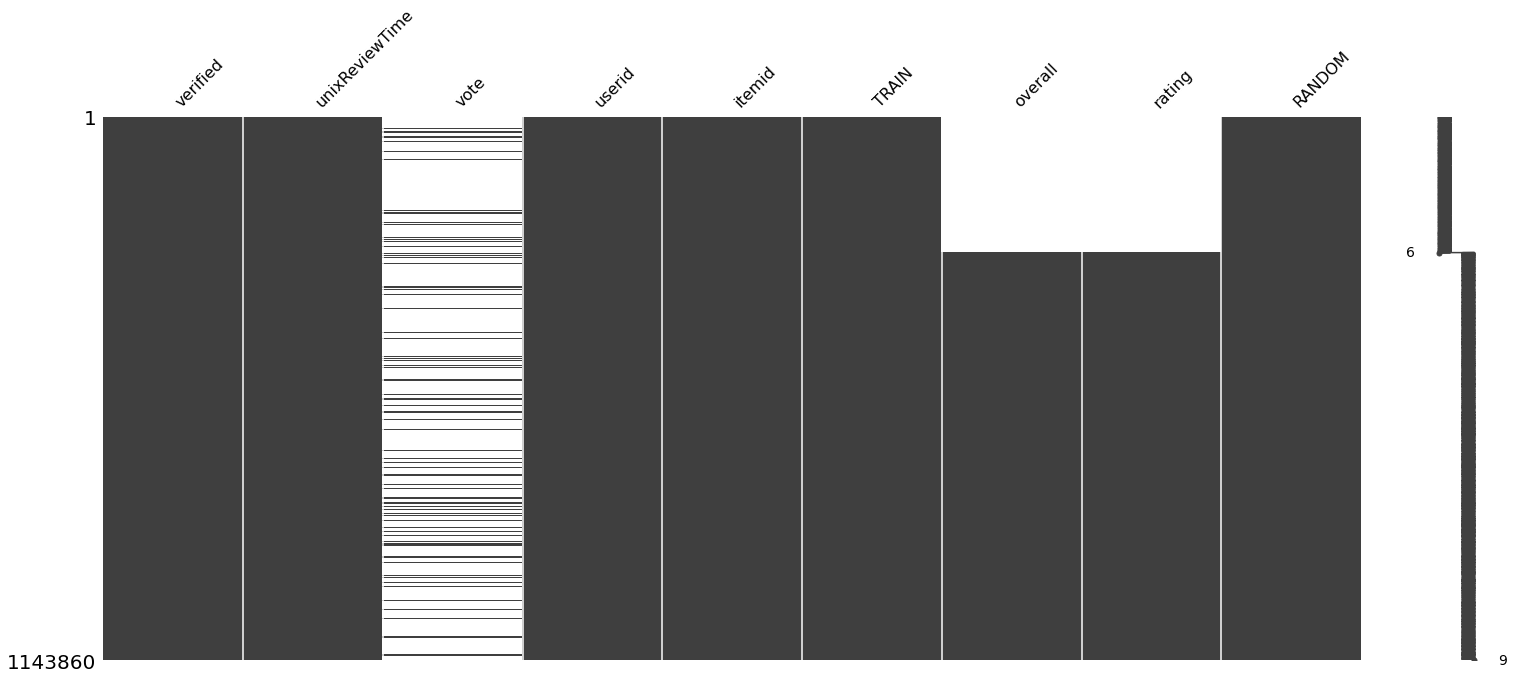

In [13]:
msno.matrix(df);

**Declare target variable, quantity, ordinal and categorical features**

In [14]:
def declare_features_type():
    """Declare target variable, quantity, ordinal and categorical features"""
    global categ_bin_cols, categ_many_cols, categ_multi_cols, categ_cols
    global quantity_cols, quantity_categ_cols, ordinal_cols
    
    # Declare categorical features
    categ_bin_cols = [
        'verified',
    ]
    categ_many_cols = [
    ]
    categ_multi_cols = [
    ]

    # Declare quantity features
    quantity_cols = [
        RANDOM,
        'unixReviewTime',
        'vote',
        'userid',
        'itemid',
    ]

    # Declare categorized quantity features
    quantity_categ_cols = [
    ]

    # Declare ordinal features
    ordinal_cols = [
    ]

    # Update quantity, ordinal and categorical feature lists
    categ_bin_cols = [col for col in categ_bin_cols if col in df.columns]
    categ_many_cols = [col for col in categ_many_cols if col in df.columns]
    categ_multi_cols = [col for col in categ_multi_cols if col in df.columns]
    categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
    quantity_cols = [col for col in quantity_cols if col in df.columns]
    quantity_categ_cols = [col for col in quantity_categ_cols if col in df.columns]
    ordinal_cols = [col for col in ordinal_cols if col in df.columns]
    
declare_features_type()

**View unique values**

In [15]:
# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Find and show number of unique values of categorical features
categorical_unique_test = {}
categorical_unique_train = {}
categorical_unique = {}
for column in categ_cols:
    # Handle categ_multi_cols features
    if column in categ_multi_cols:
        categorical_unique_test[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & (df[TRAIN] == 0), column].str.split('|')))).sort_values(ascending=False)
        categorical_unique_train[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & (df[TRAIN] == 1), column].str.split('|')))).sort_values(ascending=False)
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].str.split('|')))).sort_values(ascending=False)

    # Handle categ_bin_cols and categ_many_cols features
    else:
        categorical_unique_test[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & (df[TRAIN] == 0), column].apply(lambda x: [x])))).sort_values(ascending=False)
        categorical_unique_train[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & (df[TRAIN] == 1), column].apply(lambda x: [x])))).sort_values(ascending=False)
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].apply(lambda x: [x])))).sort_values(ascending=False)

    # Show result
    print((column + ':').ljust(22)
          + str(len(categorical_unique_test[column])).rjust(8)
          + str(len(categorical_unique_train[column])).rjust(8)
          + str(len(categorical_unique[column])).rjust(8))

                         Test:  Train:    All:
verified:                    2       2       2


In [16]:
# Parameters
ALPHABET_ORDER = False

# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Show unique values of categorical features
for column in categ_cols:
    print(column + ':')
    for i in categorical_unique[column].sort_index().index if ALPHABET_ORDER \
      else categorical_unique[column].index:
        print(str(i).ljust(22), end='')
        if i in categorical_unique_test[column].index:
            print(str(categorical_unique_test[column].at[i]).rjust(8), end='')
        else:
            print(str(0).rjust(8), end='')
        if i in categorical_unique_train[column].index:
            print(str(categorical_unique_train[column].at[i]).rjust(8), end='')
        else:
            print(str(0).rjust(8), end='')
        print(str(categorical_unique[column].at[i]).rjust(8))
    print()

                         Test:  Train:    All:
verified:
True                    248604  745243  993847
False                    37361  112652  150013



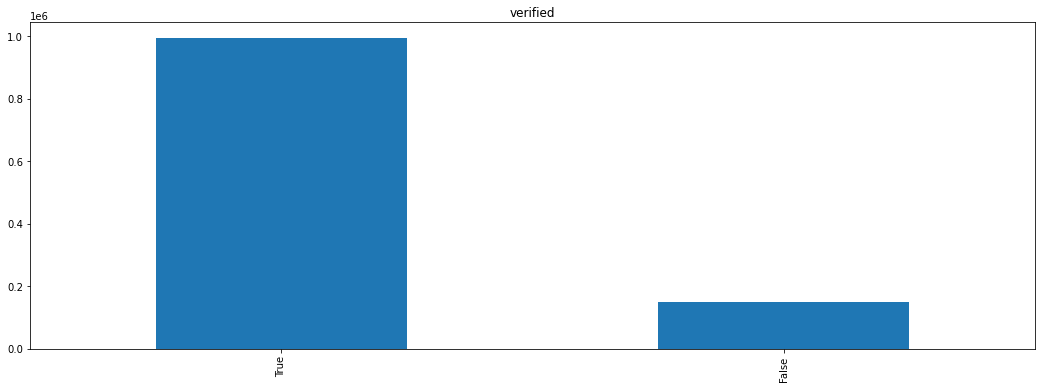

In [17]:
# Show distribution of categorical features
for column in categ_cols:
    categorical_unique[column].plot.bar(figsize=(18, 6), title=column)
    plt.show()

In [18]:
# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Show number of unique values of quantity and ordinal features
for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    print((column + ':').ljust(22)
          + (str(df.loc[df[TRAIN] == 0, column].nunique()).rjust(8))
          + (str(df.loc[df[TRAIN] == 1, column].nunique()).rjust(8))
          + (str(df[column].nunique()).rjust(8)))

                         Test:  Train:    All:
RANDOM:                 248778  575739  681250
unixReviewTime:           4349    4580    4622
vote:                      198     311     333
userid:                 109357  127448  127496
itemid:                  37876   41302   41320


In [19]:
# Show unique values of quantity and ordinal features
columns = ['vote',]

for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    if column in columns:
        print(('Test:  ' + column + ':').ljust(22), end='')
        print(np.sort(df.loc[df[TRAIN] == 0, column].unique()))
        print(('Train: ' + column + ':').ljust(22), end='')
        print(np.sort(df.loc[df[TRAIN] == 1, column].unique()))
        print(('All:   ' + column + ':').ljust(22), end='')
        print(np.sort(df[column].unique()))
        print()

Test:  vote:          [2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00 7.000e+00 8.000e+00
 9.000e+00 1.000e+01 1.100e+01 1.200e+01 1.300e+01 1.400e+01 1.500e+01
 1.600e+01 1.700e+01 1.800e+01 1.900e+01 2.000e+01 2.100e+01 2.200e+01
 2.300e+01 2.400e+01 2.500e+01 2.600e+01 2.700e+01 2.800e+01 2.900e+01
 3.000e+01 3.100e+01 3.200e+01 3.300e+01 3.400e+01 3.500e+01 3.600e+01
 3.700e+01 3.800e+01 3.900e+01 4.000e+01 4.100e+01 4.200e+01 4.300e+01
 4.400e+01 4.500e+01 4.600e+01 4.700e+01 4.800e+01 4.900e+01 5.000e+01
 5.100e+01 5.200e+01 5.300e+01 5.400e+01 5.500e+01 5.600e+01 5.700e+01
 5.800e+01 5.900e+01 6.000e+01 6.100e+01 6.200e+01 6.300e+01 6.400e+01
 6.500e+01 6.600e+01 6.700e+01 6.800e+01 6.900e+01 7.000e+01 7.100e+01
 7.200e+01 7.300e+01 7.400e+01 7.500e+01 7.600e+01 7.700e+01 7.800e+01
 7.900e+01 8.000e+01 8.100e+01 8.200e+01 8.300e+01 8.400e+01 8.500e+01
 8.600e+01 8.700e+01 8.800e+01 8.900e+01 9.000e+01 9.100e+01 9.200e+01
 9.300e+01 9.400e+01 9.500e+01 9.600e+01 9.900e+01 1.00

## Visualization

In [20]:
def show_boxplots(df, show_target=False):
    """Show boxplots of quantity and ordinal features and check them for outliers existance"""
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 5
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].boxplot(df.loc[df[column].notna(), column], showmeans=True)
        axs[idx].set_title(column)
        

def show_histograms(df, show_target=False):
    """Show distributions of quantity and ordinal features"""
    # Parameters
    DEFAULT_BINS = 50
    
    # Fill the list of bins' step if know it
    bin_step = {
        'overall': 1,
    }
    
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil(len(columns)/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        # Calculate indices of subplots
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)

        # Calculate number of bins and ranges
        if column in bin_step.keys():
            col_max = df[column].max()
            col_min = df[column].min()
            step = bin_step[column]
            offset = step / 2
            bins = int((col_max-col_min) / step) + 1
            range_ = (col_min - offset, col_max + offset)
        elif column in ordinal_cols:
            col_max = df[column].max()
            col_min = df[column].min()
            bins = int((col_max-col_min) * 2) + 1
            range_ = (col_min - 0.25, col_max + 0.25)
        else:
            bins = DEFAULT_BINS
            range_ = None

        # Plot
        axs[idx].hist(df.loc[df[column].notna(), column], bins, range_)
        axs[idx].set_title(column)
        
        
def show_scatters(df, point_size=None):
    """Show scatter plots of quantity and ordinal features from TARGET"""
    # Define columns to plot
    columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].scatter(x=df.loc[df[column].notna() & (df[TRAIN] == 1), column],
                         y=df.loc[df[column].notna() & (df[TRAIN] == 1), TARGET],
                         s=point_size)
        axs[idx].set_title(column)

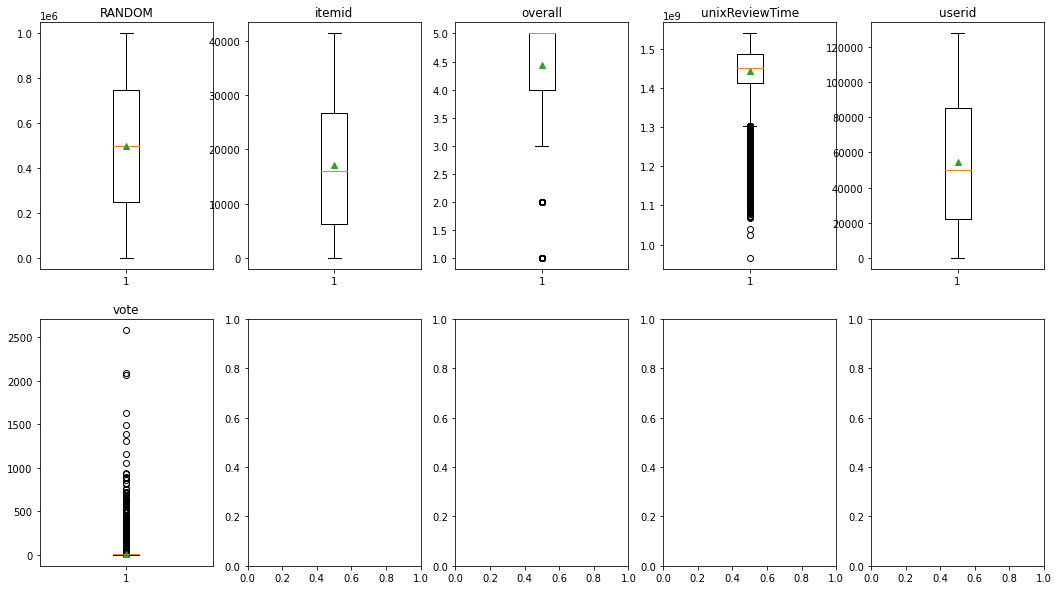

In [21]:
show_boxplots(df, show_target=True)

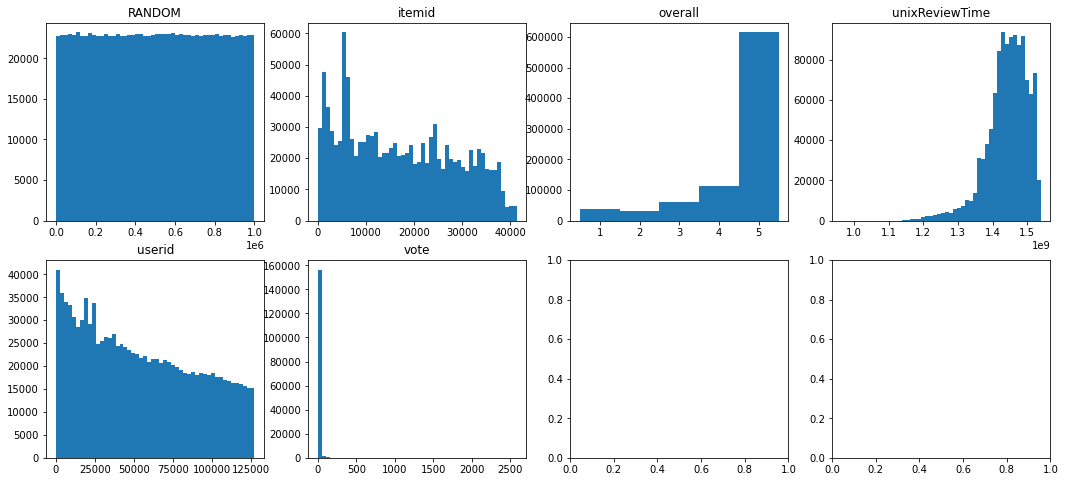

In [22]:
show_histograms(df, show_target=True)

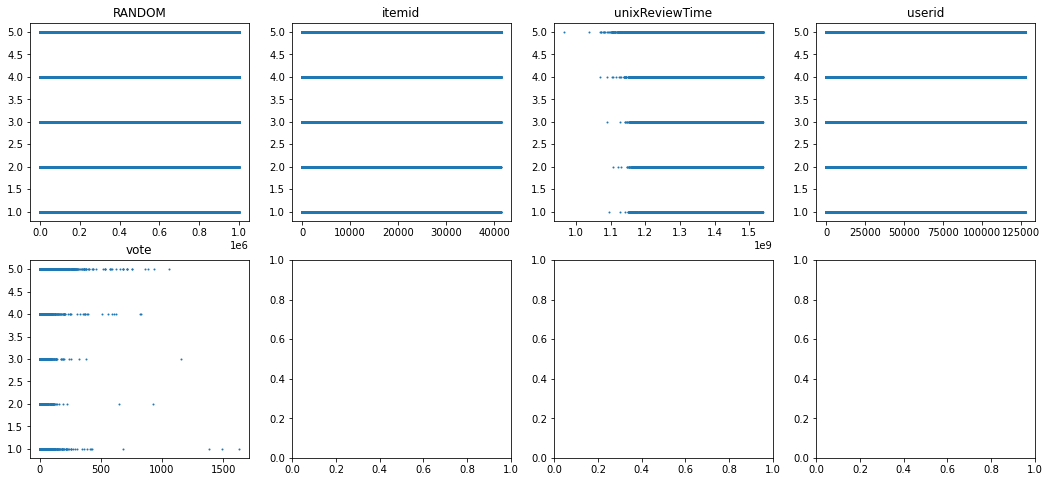

In [23]:
show_scatters(df, point_size=1)

## Outliers handling

In [24]:
def delete_outliers(df, inplace=False):
    """Show number of outliers and delete rows with outliers"""
    # Define columns to show graphs
    columns = sorted(quantity_cols).copy()
    
    # Exclude some columns from the process
    cols = [

    ]
    for col in df.columns:
        if col in cols:
            columns.remove(col)
    
    idx_dict = {}
    for column in columns:
        # Calculate Q1, Q3, IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate indices of rows
        idx_dict[column] = list(df.loc[(~df[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR))
                                       & (df[column].notna()), column].index)

        # Show the result
        outliers_num = len(idx_dict[column])
        if outliers_num:
            print(f"{str(outliers_num).rjust(6)} outliers are in column '{column}'")
            
    # Union indices
    idx = set()
    for column in columns:
        idx.update(idx_dict[column])

    # Drop rows with outliers
    if inplace:
        df.drop(idx, inplace=True)
        print(f"{str(len(idx)).rjust(6)} rows have been dropped")

In [25]:
# Show or delete outliers
print('train:')
delete_outliers(df.loc[df[TRAIN] == 1], inplace=DROP_AVAL)
print('test:')
delete_outliers(df.loc[df[TRAIN] == 0], inplace=DROP_AVAL)
print('join:')
delete_outliers(df, inplace=DROP_AVAL)

train:
 26814 outliers are in column 'unixReviewTime'
 10780 outliers are in column 'vote'
test:
  8851 outliers are in column 'unixReviewTime'
  3612 outliers are in column 'vote'
join:
 35665 outliers are in column 'unixReviewTime'
 14392 outliers are in column 'vote'


## Correlation analysis

In [26]:
# Calculate correlation matrix
corr_table = df.loc[df[TRAIN] == 1].drop(TRAIN, axis=1).corr()
corr_table

,verified,unixReviewTime,vote,userid,itemid,overall,rating,RANDOM
verified,1.000000,0.135209,-0.045690,0.052519,-0.023189,0.093266,0.072735,0.000266
unixReviewTime,0.135209,1.000000,-0.094654,0.161879,0.325628,0.019756,0.013242,-0.002260
vote,-0.045690,-0.094654,1.000000,-0.018485,-0.017593,-0.005140,-0.000588,0.000984
userid,0.052519,0.161879,-0.018485,1.000000,0.241030,-0.007821,-0.010240,-0.000034
itemid,-0.023189,0.325628,-0.017593,0.241030,1.000000,-0.027214,-0.026425,0.000238
overall,0.093266,0.019756,-0.005140,-0.007821,-0.027214,1.000000,0.897339,-0.002345
rating,0.072735,0.013242,-0.000588,-0.010240,-0.026425,0.897339,1.000000,-0.002315
RANDOM,0.000266,-0.002260,0.000984,-0.000034,0.000238,-0.002345,-0.002315,1.000000


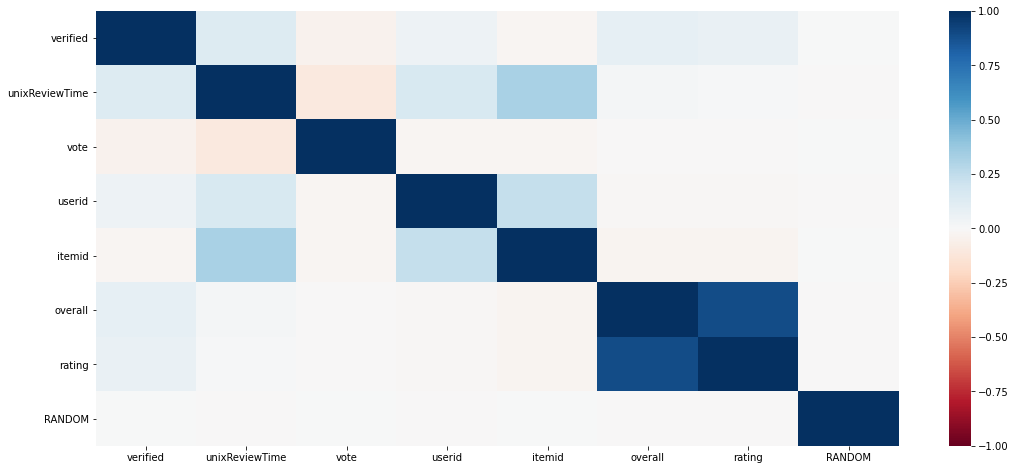

In [27]:
# Show correlation matrix
plt.subplots(figsize=(18, 8))
sns.heatmap(corr_table, vmin=-1, vmax=1, cmap="RdBu");

In [28]:
# Sort absolute correlation values with target variable
corr_table[TARGET].abs().sort_values(ascending=False)

overall           1.000000
rating            0.897339
verified          0.093266
itemid            0.027214
unixReviewTime    0.019756
userid            0.007821
vote              0.005140
RANDOM            0.002345
Name: overall, dtype: float64

## Significance analysis of categorical features
### Student's t-test

С помощью теста Стьюдента проверим есть ли статистически значимая разница в распределении целевой переменной для разных значений категориальных признаков. Проверяем нулевую гипотезу о том, что распределения целевой переменной по различным значениям категориальных переменных неразличимы.

In [29]:
def hypothesis_testing(df):
    """Hypothesis testing of significance analysis"""
    NUM_OF_VALS = 10

    # Find not significant features
    mask = {}
    top_values = {}
    not_signif_columns = []
    for column in categ_cols:
        # Find top NUM_OF_VALS values
        top_values[column] = categorical_unique[column].index[:NUM_OF_VALS]

        # Find boolean masks
        mask[column] = {}
        for value in top_values[column]:
            if column in categ_multi_cols:
                mask[column][value] = (df[column].str.contains(
                    '(?:^|\|)'+value+'(?:$|\|)'
                )) & (df[TARGET].notna())
            else:
                mask[column][value] = (df[column] == value) & (df[TARGET].notna())

        # Student t-test for value combinations
        combs = list(combinations(top_values[column], 2))
        for comb in combs:
            if stats.ttest_ind(df.loc[mask[column][comb[0]], TARGET], 
                         df.loc[mask[column][comb[1]], TARGET]) \
                            .pvalue <= 0.05/len(combs): # Bonferroni correction
                break
        else:
            not_signif_columns.append(column)

    # Show result
    if len(not_signif_columns):
        print('Statistically significant differences have NOT been found for features:')
        for column in not_signif_columns:
            print(f"'{column}'")
    else:
        print('All categorical features have statistically significant difference with target')
        
    return (top_values, mask)


def boxplot_significance(df, top_values, mask):
    """Show boxplots of features to view significance"""
    # Create figure with [rows x cols] graphs
    rows = len(categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(categ_cols):
        if rows == 1:
            axs.boxplot([df.loc[mask[column][value], TARGET] \
                         for value in top_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_values[column], rotation=5)
            axs.set_ylabel(TARGET)
        else:
            axs[i].boxplot([df.loc[mask[column][value], TARGET] \
                            for value in top_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_values[column], rotation=5)
            axs[i].set_ylabel(TARGET)

All categorical features have statistically significant difference with target


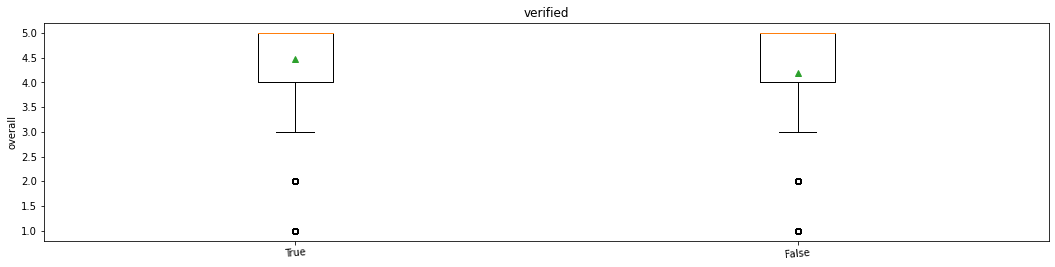

In [30]:
# Do hypothesis testing and show boxplots of significant features
top_values, mask = hypothesis_testing(df.loc[df[TRAIN] == 1])
boxplot_significance(df.loc[df[TRAIN] == 1], top_values, mask)

## Missing values handling

In [31]:
def fill_missing_values(df):
    """Fill missing values (NaNs) for columns"""
    # Fill missing values
    for column in quantity_cols + ordinal_cols + categ_cols:
        # Calculate number of replaced values
        nan_number = df[column].isna().sum()
        
        if nan_number:
            # For individual columns
            if column == 'vote':
                value = 1
                
            # For groups of columns
            elif column in quantity_cols:
                value = df[column].mean()

            elif column in ordinal_cols:
                value = df[column].mode()[0]

            elif column in categ_bin_cols:
                value = categorical_unique[column].index[0]

            elif column in categ_many_cols:
                value = categorical_unique[column].index[0]

            elif column in categ_multi_cols:
                values_num = round(df.loc[df[column].notna(),
                                          column].apply(lambda x: len(x.split('|'))).mean())
                value = '|'.join(categorical_unique[column].index[:values_num])

            # Replace
            df[column].fillna(value, inplace=True)
            
            # Show number of replaced values in column
            print(f"{str(nan_number).rjust(6)} NaN have been replaced in column '{column}'")

In [32]:
# Fill missing values
fill_missing_values(df)

985658 NaN have been replaced in column 'vote'


## Dummies generation

In [33]:
def generate_dummies(df, collinear_sens):
    """Dummies generation from categorical features
    
    collinear_sens is ML model collinearity sensitivity. It's either True or False.
    """
    # Generate dummies for categ_multi_cols
    for column in categ_multi_cols:
        df = pd.concat([df, df[column].str.get_dummies()], axis=1)
    df.drop(categ_multi_cols, axis=1, inplace=True)

    # Generate dummies for categ_bin_cols and categ_many_cols
    df = pd.get_dummies(df, columns=categ_bin_cols+categ_many_cols, drop_first=collinear_sens)

    return df

In [34]:
# Generate dummies
df = generate_dummies(df, collinear_sens=False)

# Model implementation

## Data preparing

In [35]:
# Prepare data
df, sample_submission = collect_data()
format_features(df)
create_new_features(df)
delete_useless_features(df)
declare_features_type()
delete_outliers(df, inplace=DROP_AVAL)
fill_missing_values(df)
df = generate_dummies(df, collinear_sens=False)

df_temp = df.copy()
df_temp

 35665 outliers are in column 'unixReviewTime'
 14392 outliers are in column 'vote'
985658 NaN have been replaced in column 'vote'


,unixReviewTime,vote,userid,itemid,TRAIN,overall,rating,RANDOM,verified_False,verified_True
0,1475280000,1.0,68877,7506,0,NaN,NaN,89250,0,1
1,1404000000,2.0,50442,15530,0,NaN,NaN,773956,0,1
2,1431993600,1.0,64349,15049,0,NaN,NaN,654571,0,1
3,1412467200,1.0,26206,11957,0,NaN,NaN,438878,0,1
4,1384128000,3.0,59366,12173,0,NaN,NaN,433015,0,1
...,...,...,...,...,...,...,...,...,...,...
1143855,1364860800,1.0,59433,2566,1,5.0,1.0,199302,0,1
1143856,1449964800,1.0,86473,5828,1,2.0,0.0,212603,0,1
1143857,1474416000,1.0,88,3251,1,4.0,1.0,500410,1,0
1143858,1446336000,1.0,41540,22208,1,4.0,1.0,442702,0,1


In [36]:
df = df_temp.copy()

## Data splitting & Data scaling

In [37]:
def split_dataframe(data, test_size, stratify=True, normalize=True):
    """Split dataframe to: X_y, X_y_train, X_y_test"""
    # Split data: Х - features, у - target variable
    X_y = data.loc[data[TRAIN] == 1].drop([TRAIN], axis=1)
    y = data.loc[data[TRAIN] == 1, TARGET].values

    # Split data on train and test parts
    strat = y if stratify else None
    X_y_train, X_y_test = train_test_split(
        X_y, test_size=test_size, stratify=strat, shuffle=True, random_state=RANDOM_SEED
    )

    if normalize:
        scaler = StandardScaler()
        X_y = pd.DataFrame(scaler.fit_transform(X_y), columns=X_y.columns)
        X_y_train = pd.DataFrame(scaler.fit_transform(X_y_train), columns=X_y_train.columns)
        X_y_test = pd.DataFrame(scaler.fit_transform(X_y_test), columns=X_y_test.columns)

    return (X_y, X_y_train, X_y_test)

In [38]:
# Data splitting
X_y, X_y_train, X_y_test = split_dataframe(df, test_size=0.2, normalize=False)
print('Shapes:', X_y.shape, X_y_train.shape, X_y_test.shape)

Shapes: (857895, 9) (686316, 9) (171579, 9)


In [39]:
X_y_train_sparse = sparse.coo_matrix((X_y_train['rating'],
                                     (X_y_train['userid'],
                                      X_y_train['itemid'])))

In [40]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.1,
                loss='logistic',
                no_components=NUM_COMPONENTS)

model = model.fit(X_y_train_sparse,
                  epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

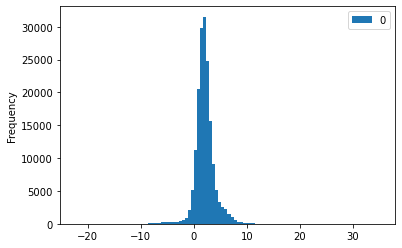

In [41]:
preds = model.predict(X_y_test['userid'].values,
                      X_y_test['itemid'].values)

pd.DataFrame(preds).plot.hist(bins=100);

In [42]:
roc_auc_score(X_y_test['rating'], preds)

0.7496764848843464

# Submission
**Learn model on 100% of train data**

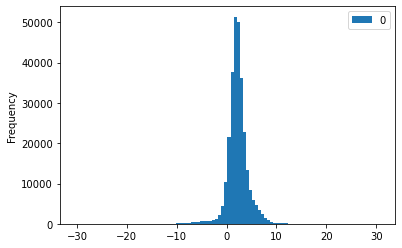

In [43]:
# Create and learn model
model = LightFM(learning_rate=0.1,
                loss='logistic',
                no_components=30)
model = model.fit(sparse.coo_matrix((X_y['rating'],
                                    (X_y['userid'],
                                     X_y['itemid']))),
                  epochs=20, 
                  num_threads=4)

# Splitting data to predict
X_y_predict = df.loc[df[TRAIN] == 0]

# Predict
predict_submission = model.predict(X_y_predict['userid'].values,
                                   X_y_predict['itemid'].values)
pd.DataFrame(predict_submission).plot.hist(bins=100);

**Postprocess**

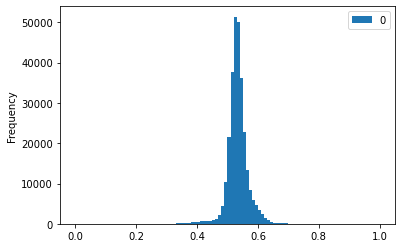

In [44]:
predict_submission_post = (predict_submission - predict_submission.min()) \
    / (predict_submission - predict_submission.min()).max()
pd.DataFrame(predict_submission_post).plot.hist(bins=100);

**Write result to submission file**

In [45]:
sample_submission['rating'] = predict_submission_post
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,Id,rating
0,0,0.532565
1,1,0.520678
2,2,0.505739
3,3,0.508170
4,4,0.531655
...,...,...
285960,285960,0.539590
285961,285961,0.422989
285962,285962,0.494436
285963,285963,0.532642
